In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from decimal import Decimal
from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import MinMaxScaler,LabelEncoder,RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

import xgboost as xgb
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 

from mlxtend.regressor import StackingRegressor

In [30]:
from sklearn.metrics import classification_report

In [3]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [4]:
file = pd.ExcelFile('../Datasets/Data science assignment.xlsx')
df_input = file.parse('Sheet4')

In [5]:
indata = df_input.copy(deep=False)

In [6]:
indata.head().round(3)

,MMV,Make,Model,Variant,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
0,HyundaiI10Sportz 1.2,Hyundai,I10,Sportz 1.2,Hatchback,Petrol,3,Manual,White,12000,1,8.5,8.8,537849.665,338352.0,37.092
1,HyundaiI20Magna (O) 1.2,Hyundai,I20,Magna (O) 1.2,Hatchback,Petrol,9,Manual,Beige,68000,1,5.0,7.3,613862.680,189200.0,69.179
2,HyundaiI20Sportz 1.2,Hyundai,I20,Sportz 1.2,Hatchback,Petrol,8,Manual,White,31143,1,6.2,4.6,678358.572,347568.0,48.763
3,HyundaiNeo Fluidic Elantra1.6SxAtCrdi,Hyundai,Neo Fluidic Elantra,1.6SxAtCrdi,Sedan,Diesel,2,Automatic,Silver,6000,1,8.5,7.9,2228480.499,1629250.0,26.890
4,HyundaiSantro XingXo,Hyundai,Santro Xing,Xo,Hatchback,Petrol,11,Manual,Golden,100000,2,4.3,9.9,453719.368,86240.0,80.993


In [6]:
indata.shape

(3879, 16)

In [7]:
indata.columns

Index(['MMV', 'Make', 'Model', 'Variant', 'Type', 'Fuel Type', 'Age',
       'Transmission', 'Color', 'Kms', 'No of Owner', 'Heath score',
       'price score', 'on road price', 'Current Price', 'Dep'],
      dtype='object')

In [8]:
indata.describe()

,Age,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
count,3879.000000,3879.000000,3879.000000,3879.000000,3879.000000,3.879000e+03,3.879000e+03,3879.000000
mean,7.274040,56812.587523,1.226605,5.697602,6.849368,9.381424e+05,4.130298e+05,54.342586
std,2.695272,46163.397216,0.549230,1.620505,1.926978,5.841469e+05,3.030802e+05,17.235352
min,1.000000,863.000000,1.000000,3.300000,3.200000,2.372747e+05,5.192000e+04,2.071667
25%,5.000000,38000.000000,1.000000,4.500000,5.200000,5.378497e+05,2.335180e+05,42.215315
50%,7.000000,53000.000000,1.000000,5.000000,6.800000,7.819281e+05,3.291520e+05,55.280421
75%,9.000000,68575.500000,1.000000,6.800000,8.400000,1.120298e+06,4.877280e+05,67.248878
max,12.000000,854995.000000,6.000000,9.900000,9.900000,1.095466e+07,2.974683e+06,92.453905


In [9]:
indata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3879 entries, 0 to 3878
Data columns (total 16 columns):
MMV              3879 non-null object
Make             3879 non-null object
Model            3879 non-null object
Variant          3879 non-null object
Type             3879 non-null object
Fuel Type        3879 non-null object
Age              3879 non-null int64
Transmission     3879 non-null object
Color            3879 non-null object
Kms              3879 non-null int64
No of Owner      3879 non-null int64
Heath score      3879 non-null float64
price score      3879 non-null float64
on road price    3879 non-null float64
Current Price    3879 non-null float64
Dep              3879 non-null float64
dtypes: float64(5), int64(3), object(8)
memory usage: 485.0+ KB


###  Finding the categorical features

In [10]:
def listFactorVars(dataFrame):
    for col in dataFrame:
        if (len(indata[col].unique()) < 15):
            print("{} : {}".format(col, indata[col].unique()))
        else:
            None

catCols=listFactorVars(indata)
display(catCols)

Make : ['Hyundai' 'Honda' 'Maruti Suzuki' 'Toyota']
Type : ['Hatchback' 'Sedan' 'SUV' 'MUV' 'Van' 'Crossover']
Fuel Type : ['Petrol' 'Diesel' 'Petrol + CNG' 'diesel' 'CNG' 'cng' 'Petrol + LPG'
 'LPG']
Age : [ 3  9  8  2 11 10  4  7 12  6  5  1]
Transmission : ['Manual' 'Automatic' 'Automated Manual Transmission']
No of Owner : [1 2 3 5 4 6]


None

####  Converting all values to uppercase of column 'Fuel Type'

In [7]:
indata['Fuel Type'] = indata['Fuel Type'].map(lambda x: x.upper())
indata['Fuel Type'].value_counts()

PETROL          2754
DIESEL           907
PETROL + CNG     143
CNG               67
PETROL + LPG       7
LPG                1
Name: Fuel Type, dtype: int64

#### Checking for Null values

In [12]:
indata.isnull().sum()

MMV              0
Make             0
Model            0
Variant          0
Type             0
Fuel Type        0
Age              0
Transmission     0
Color            0
Kms              0
No of Owner      0
Heath score      0
price score      0
on road price    0
Current Price    0
Dep              0
dtype: int64

In [13]:
indata.shape

(3879, 16)

#### Checking for duplicate rows

In [14]:
indata[indata.duplicated(keep=False)].sort_values('MMV')

,MMV,Make,Model,Variant,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
597,HyundaiAccentGLE,Hyundai,Accent,GLE,Sedan,PETROL,6,Manual,Red,27639,1,6.8,5.6,691110.636000,265200.0,61.626983
737,HyundaiAccentGLE,Hyundai,Accent,GLE,Sedan,PETROL,6,Manual,Red,27639,1,6.8,5.6,691110.636000,265200.0,61.626983
493,HyundaiI10Magna,Hyundai,I10,Magna,Hatchback,PETROL,8,Manual,Grey,37502,1,6.8,3.8,462988.362962,260662.0,43.700097
613,HyundaiI10Magna,Hyundai,I10,Magna,Hatchback,PETROL,8,Manual,Grey,37502,1,6.8,3.8,462988.362962,260662.0,43.700097
607,HyundaiI10Sportz 1.2,Hyundai,I10,Sportz 1.2,Hatchback,PETROL,9,Manual,Red,23949,1,6.8,6.4,537849.665431,215600.0,59.914449
688,HyundaiI10Sportz 1.2,Hyundai,I10,Sportz 1.2,Hatchback,PETROL,9,Manual,Red,23949,1,6.8,6.4,537849.665431,215600.0,59.914449
639,HyundaiSantro XingGLS,Hyundai,Santro Xing,GLS,Hatchback,PETROL,9,Manual,Blue,56530,1,6.4,5.8,457174.148600,176000.0,61.502635
642,HyundaiSantro XingGLS,Hyundai,Santro Xing,GLS,Hatchback,PETROL,9,Manual,Blue,56530,1,6.4,5.8,457174.148600,176000.0,61.502635
464,HyundaiVernaVGT CRDi,Hyundai,Verna,VGT CRDi,Sedan,DIESEL,9,Manual,White,62251,1,6.4,9.2,874470.885161,287950.0,67.071517
585,HyundaiVernaVGT CRDi,Hyundai,Verna,VGT CRDi,Sedan,DIESEL,9,Manual,White,62251,1,6.4,9.2,874470.885161,287950.0,67.071517


In [8]:
indata.drop_duplicates(inplace=True)
indata.shape

(3871, 16)

#### Checking few other columns

In [16]:
indata['MMV'].nunique()

563

In [17]:
indata['Model'].nunique()

66

In [18]:
indata['Color'].nunique()

43

In [19]:
indata['Variant'].nunique()

474

#### Taking an insight on the features based on the manufacturer

In [20]:
indata.groupby('Make')['Kms', 'No of Owner', 'Heath score','price score'].describe().transpose().round(2)

Make                   Honda    Hyundai  Maruti Suzuki     Toyota
Kms         count     863.00    1007.00        1529.00     472.00
            mean    58012.98   47755.69       56446.03   75307.06
            std     37568.81   40403.53       52842.73   43476.51
            min       863.00    1000.00        1285.00    4500.00
            25%     43335.50   31000.00       38084.00   46000.00
            50%     56456.00   45628.00       51658.00   68000.00
            75%     70000.00   60000.00       67000.00   93023.25
            max    740000.00  846004.00      854995.00  460000.00
No of Owner count     863.00    1007.00        1529.00     472.00
            mean        1.28       1.18           1.22       1.25
            std         0.57       0.46           0.57       0.61
            min         1.00       1.00           1.00       1.00
            25%         1.00       1.00           1.00       1.00
            50%         1.00       1.00           1.00       1.00
            75%         1.00       1.00           1.00       1.00
            max         5.00       5.00           6.00       6.00
Heath score count     863.00    1007.00        1529.00     472.00
            mean        5.80       5.74           5.70       5.38
            std         1.58       1.62           1.61       1.71
            min         3.30       3.30           3.30       3.30
            25%         4.50       4.50           4.50       4.30
            50%         5.00       5.00           5.00       4.80
            75%         6.80       6.80           6.80       6.40
            max         9.90       9.90           9.90       9.90
price score count     863.00    1007.00        1529.00     472.00
            mean        7.80       6.73           6.27       7.26
            std         1.90       1.79           1.78       1.96
            min         3.40       3.20           3.20       3.20
            25%         6.40       5.20           4.70       5.60
            50%         8.20       6.70           6.00       7.40
            75%         9.40       8.15           7.40       9.10
            max         9.90       9.90           9.90       9.90

In [21]:
indata.groupby('Make')['Heath score','on road price', 'Current Price', 'Dep'].describe().transpose().round(2)

Make                      Honda     Hyundai  Maruti Suzuki       Toyota
Heath score   count      863.00     1007.00        1529.00       472.00
              mean         5.80        5.74           5.70         5.38
              std          1.58        1.62           1.61         1.71
              min          3.30        3.30           3.30         3.30
              25%          4.50        4.50           4.50         4.30
              50%          5.00        5.00           5.00         4.80
              75%          6.80        6.80           6.80         6.40
              max          9.90        9.90           9.90         9.90
on road price count      863.00     1007.00        1529.00       472.00
              mean   1262918.36   766658.15      638702.90   1686380.33
              std     542562.46   393349.28      202345.28    834465.38
              min     554012.00   359359.31      237274.73    560559.02
              25%     900907.00   530124.30      490492.00   1281576.00
              50%    1004692.15   639278.12      566632.69   1525510.00
              75%    1497108.30   874470.89      806540.75   1771712.00
              max    3361376.00  3908606.00     2205274.00  10954664.00
Current Price count      863.00     1007.00        1529.00       472.00
              mean    418625.13   370606.36      316530.14    809087.65
              std     212694.35   231623.00      161149.64    531711.73
              min     105600.00    51920.00       57200.00    180400.00
              25%     260662.00   224502.00      202400.00    417198.00
              50%     379950.00   309875.84      278838.00    651902.17
              75%     498622.20   457943.26      380555.09   1063125.00
              max    1686250.00  1737550.00     1087900.00   2974682.75
Dep           count      863.00     1007.00        1529.00       472.00
              mean        64.00       52.17          51.02        52.03
              std         17.23       14.72          15.76        20.25
              min          8.54        8.36           2.07         4.25
              25%         52.05       43.35          39.44        37.00
              50%         67.10       52.83          52.23        53.45
              75%         78.34       62.04          63.39        68.68
              max         92.45       90.75          89.67        89.21

#### Checking for outliners and data distribution

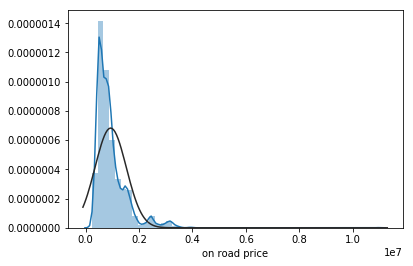

In [22]:
sns.distplot(indata['on road price'], fit=norm);

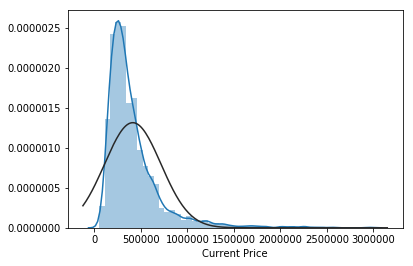

In [23]:
sns.distplot(indata['Current Price'], fit=norm);

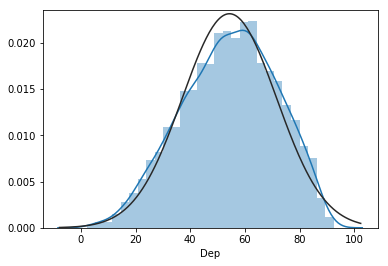

In [24]:
sns.distplot(indata['Dep'], fit=norm);

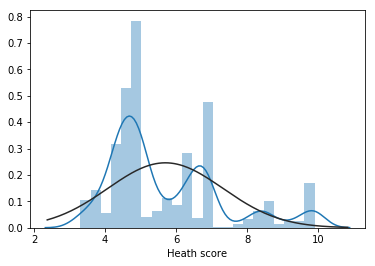

In [25]:
sns.distplot(indata['Heath score'], fit=norm);

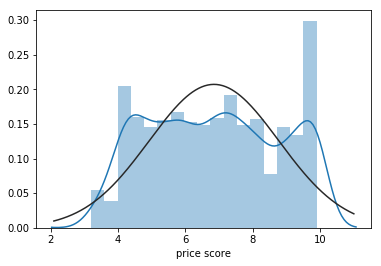

In [26]:
sns.distplot(indata['price score'], fit=norm);

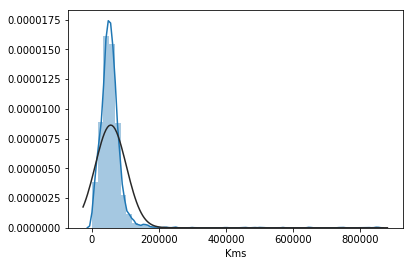

In [27]:
sns.distplot(indata['Kms'], fit=norm);

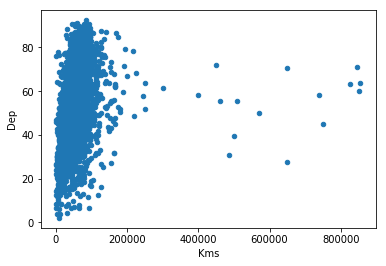

In [28]:
indata.plot('Kms','Dep',kind='scatter')

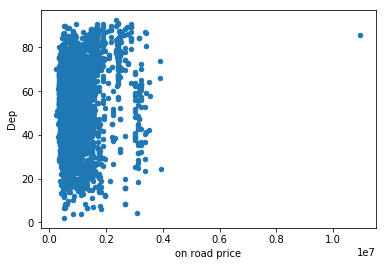

In [29]:
indata.plot('on road price','Dep',kind='scatter')

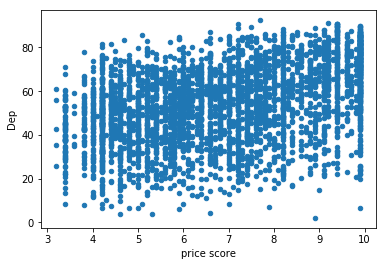

In [30]:
indata.plot('price score','Dep',kind='scatter')

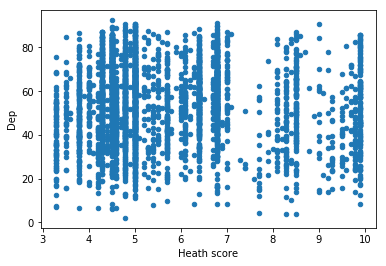

In [31]:
indata.plot('Heath score','Dep',kind='scatter')

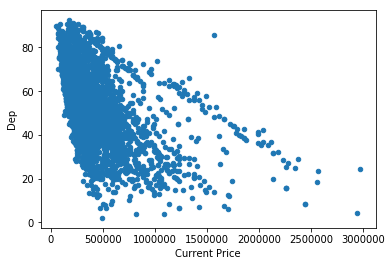

In [32]:
indata.plot('Current Price','Dep', kind='scatter')

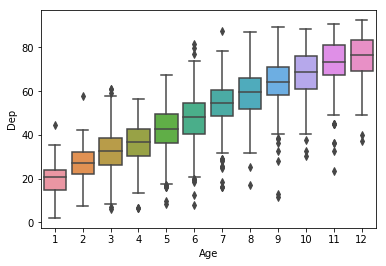

In [33]:
sns.boxplot(x='Age',y='Dep',data=indata)

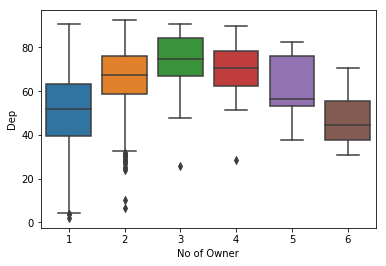

In [34]:
sns.boxplot(x='No of Owner',y='Dep',data=indata)

In [35]:
indata.sort_values('on road price',ascending=False).head()

,MMV,Make,Model,Variant,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
3724,ToyotaLand CruiserLC200 VX Premium 2,Toyota,Land Cruiser,LC200 VX Premium 2,SUV,PETROL,12,Automatic,White,80000,2,9.9,8.0,10954664.00,1567500.00,85.691026
2047,ToyotaFortunerSigma4,Toyota,Fortuner,Sigma4,SUV,DIESEL,1,Automatic,Other,25000,1,7.7,7.0,3946758.65,2974682.75,24.629727
344,HyundaiSanta Fe4WD AT,Hyundai,Santa Fe,4WD AT,SUV,DIESEL,7,Automatic,White,60710,2,4.8,8.1,3908606.00,1018656.00,73.938125
363,HyundaiSanta Fe4WD AT,Hyundai,Santa Fe,4WD AT,SUV,DIESEL,6,Automatic,White,57000,1,6.0,9.9,3908606.00,1330000.00,65.972523
2046,ToyotaFortuner2.84x4Mt,Toyota,Fortuner,2.84x4Mt,SUV,DIESEL,6,Manual,White,84000,2,3.5,8.2,3554355.85,1496250.00,57.903765


In [35]:
#indata = indata.drop(indata[indata['on road price'] == 10954664.00].index)

In [36]:
indata.sort_values('Current Price',ascending=False).head()

,MMV,Make,Model,Variant,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
2047,ToyotaFortunerSigma4,Toyota,Fortuner,Sigma4,SUV,DIESEL,1,Automatic,Other,25000,1,7.7,7.0,3.946759e+06,2974682.75,24.629727
2178,ToyotaFortuner2.74x2Mt,Toyota,Fortuner,2.74x2Mt,SUV,PETROL,1,Manual,White,30420,1,7.7,6.6,3.075816e+06,2945000.00,4.253046
2521,ToyotaFortuner3.0 4x4 AT,Toyota,Fortuner,3.0 4x4 AT,SUV,DIESEL,2,Automatic,White,23000,1,3.3,6.1,3.354590e+06,2565000.00,23.537596
159,ToyotaFortuner3.0 4x2 AT,Toyota,Fortuner,3.0 4x2 AT,SUV,DIESEL,3,Automatic,White,23163,1,4.0,4.4,3.133263e+06,2560250.00,18.288071
2215,ToyotaFortuner4x2 AT,Toyota,Fortuner,4x2 AT,SUV,DIESEL,3,Automatic,White,16000,1,9.9,6.0,2.671469e+06,2446250.00,8.430530


In [9]:
indata = indata.drop(indata[indata['Kms'] > 800000].index)

In [10]:
indata = indata.drop(indata[indata['Current Price'] > 2800000].index)

In [39]:
indata.loc[(indata['Dep'] < 40) & indata['No of Owner'].isin([3,4])]

,MMV,Make,Model,Variant,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
2235,Maruti SuzukiWagon RLXI,Maruti Suzuki,Wagon R,LXI,Hatchback,PETROL,7,Manual,Grey,85903,3,5.4,3.4,475198.2,352182.000,25.887346
2324,Maruti SuzukiErtigaVXI,Maruti Suzuki,Ertiga,VXI,MUV,PETROL,3,Automatic,White,41000,4,9.3,7.0,899612.0,641199.028,28.724936


In [40]:
indata.loc[(indata['Dep'] < 20) & indata['No of Owner'].isin([2])]

,MMV,Make,Model,Variant,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
2000,ToyotaInnova2.5 V 8 STR,Toyota,Innova,2.5 V 8 STR,MUV,DIESEL,4,Manual,White,94000,2,4.2,4.8,1.322223e+06,1235000.0,6.596694
3851,HyundaiI20Sportz 1.4 CRDI,Hyundai,I20,Sportz 1.4 CRDI,Hatchback,DIESEL,2,Manual,Red,7000,2,8.4,4.3,8.404881e+05,754038.0,10.285700


In [41]:
indata.loc[(indata['Dep'] < 20) & indata['Age'].isin([8,9,10,11,12])]

,MMV,Make,Model,Variant,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
25,HyundaiI10Magna,Hyundai,I10,Magna,Hatchback,PETROL,8,Manual,White,6500,1,6.8,4.6,462988.362962,384592.0,16.932685
218,HyundaiI10Magna 1.2 Kappa2,Hyundai,I10,Magna 1.2 Kappa2,Hatchback,PETROL,9,Manual,Red,90000,1,8.3,4.0,510208.569135,450000.0,11.800776
2331,Maruti SuzukiSwiftLXi,Maruti Suzuki,Swift,LXi,Hatchback,PETROL,9,Automatic,Red,75145,1,6.4,4.2,463669.617616,403200.0,13.041531


In [42]:
indata.shape

(3865, 16)

In [11]:
indata.drop([3724,2235,2324,2000,218,2331,25], inplace=True)

In [12]:
indata.shape

(3858, 16)

#### Creating a subset of the input data

In [13]:
df_sub = indata[['Make', 'Model', 'Variant','Transmission', 'Color', 'No of Owner', 'Kms', 'Type', 'Fuel Type', 'on road price','Dep']]
df_sub.head()

,Make,Model,Variant,Transmission,Color,No of Owner,Kms,Type,Fuel Type,on road price,Dep
0,Hyundai,I10,Sportz 1.2,Manual,White,1,12000,Hatchback,PETROL,5.378497e+05,37.091715
1,Hyundai,I20,Magna (O) 1.2,Manual,Beige,1,68000,Hatchback,PETROL,6.138627e+05,69.178775
2,Hyundai,I20,Sportz 1.2,Manual,White,1,31143,Hatchback,PETROL,6.783586e+05,48.763381
3,Hyundai,Neo Fluidic Elantra,1.6SxAtCrdi,Automatic,Silver,1,6000,Sedan,DIESEL,2.228480e+06,26.889645
4,Hyundai,Santro Xing,Xo,Manual,Golden,2,100000,Hatchback,PETROL,4.537194e+05,80.992656


In [46]:
indata.head()

,MMV,Make,Model,Variant,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
0,HyundaiI10Sportz 1.2,Hyundai,I10,Sportz 1.2,Hatchback,PETROL,3,Manual,White,12000,1,8.5,8.8,5.378497e+05,338352.0,37.091715
1,HyundaiI20Magna (O) 1.2,Hyundai,I20,Magna (O) 1.2,Hatchback,PETROL,9,Manual,Beige,68000,1,5.0,7.3,6.138627e+05,189200.0,69.178775
2,HyundaiI20Sportz 1.2,Hyundai,I20,Sportz 1.2,Hatchback,PETROL,8,Manual,White,31143,1,6.2,4.6,6.783586e+05,347568.0,48.763381
3,HyundaiNeo Fluidic Elantra1.6SxAtCrdi,Hyundai,Neo Fluidic Elantra,1.6SxAtCrdi,Sedan,DIESEL,2,Automatic,Silver,6000,1,8.5,7.9,2.228480e+06,1629250.0,26.889645
4,HyundaiSantro XingXo,Hyundai,Santro Xing,Xo,Hatchback,PETROL,11,Manual,Golden,100000,2,4.3,9.9,4.537194e+05,86240.0,80.992656


#### Creating a subset 'train' from 'indata' dataframe. Dropping the columns which do not provide much information. 

In [14]:
train = indata.drop(columns=['MMV','Variant','Model'])
train.head().round(3)

,Make,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
0,Hyundai,Hatchback,PETROL,3,Manual,White,12000,1,8.5,8.8,537849.665,338352.0,37.092
1,Hyundai,Hatchback,PETROL,9,Manual,Beige,68000,1,5.0,7.3,613862.680,189200.0,69.179
2,Hyundai,Hatchback,PETROL,8,Manual,White,31143,1,6.2,4.6,678358.572,347568.0,48.763
3,Hyundai,Sedan,DIESEL,2,Automatic,Silver,6000,1,8.5,7.9,2228480.499,1629250.0,26.890
4,Hyundai,Hatchback,PETROL,11,Manual,Golden,100000,2,4.3,9.9,453719.368,86240.0,80.993


#### Encoding the string categorical features for better exploitation of information.

In [15]:
train['Make'] = train['Make'].apply(str)
train['Type'] = train['Type'].apply(str)
train['Fuel Type'] = train['Fuel Type'].apply(str)
train['Transmission'] = train['Transmission'].apply(str)
train['Color'] = train['Color'].apply(str)

cols = ('Make', 'Type', 'Fuel Type', 'Transmission', 'Color')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))

In [49]:
train.head().round(3)  

,Make,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Dep
0,1,1,3,3,2,31,12000,1,8.5,8.8,537849.665,338352.0,37.092
1,1,1,3,9,2,0,68000,1,5.0,7.3,613862.680,189200.0,69.179
2,1,1,3,8,2,31,31143,1,6.2,4.6,678358.572,347568.0,48.763
3,1,4,1,2,1,24,6000,1,8.5,7.9,2228480.499,1629250.0,26.890
4,1,1,3,11,2,10,100000,2,4.3,9.9,453719.368,86240.0,80.993


#### Dropping the target varaible 

In [16]:
dep = train['Dep']
train.drop(columns='Dep',inplace=True)

#### Scaling the data

In [99]:
#ale_data = train[['on road price', 'Current Price', 'Heath score', 'price score' , 'Kms', 'Color']]

In [17]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
train = pd.DataFrame(data=scaler.transform(train),columns = train.columns,index=train.index)

In [53]:
train.head()

,Make,Type,Fuel Type,Age,Transmission,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price
0,0.333333,0.2,0.6,0.181818,1.0,0.738095,0.014866,0.0,0.787879,0.835821,0.081871,0.113976
1,0.333333,0.2,0.6,0.727273,1.0,0.000000,0.089619,0.0,0.257576,0.611940,0.102575,0.054626
2,0.333333,0.2,0.6,0.636364,1.0,0.738095,0.040420,0.0,0.439394,0.208955,0.120143,0.117644
3,0.333333,0.8,0.2,0.090909,0.5,0.571429,0.006857,0.0,0.787879,0.701493,0.542366,0.627648
4,0.333333,0.2,0.6,0.909091,1.0,0.238095,0.132335,0.2,0.151515,1.000000,0.058955,0.013657


In [19]:
train = pd.get_dummies(train,prefix=['Make', 'Type', 'Fuel Type','Transmission'],
                       columns=['Make', 'Type', 'Fuel Type','Transmission'])

In [55]:
train.columns

Index(['Age', 'Color', 'Kms', 'No of Owner', 'Heath score', 'price score',
       'on road price', 'Current Price', 'Make_0.0', 'Make_0.3333333333333333',
       'Make_0.6666666666666666', 'Make_1.0', 'Type_0.0', 'Type_0.2',
       'Type_0.4', 'Type_0.6000000000000001', 'Type_0.8', 'Type_1.0',
       'Fuel Type_0.0', 'Fuel Type_0.2', 'Fuel Type_0.4',
       'Fuel Type_0.6000000000000001', 'Fuel Type_0.8', 'Fuel Type_1.0',
       'Transmission_0.0', 'Transmission_0.5', 'Transmission_1.0'],
      dtype='object')

In [56]:
train.head()

,Age,Color,Kms,No of Owner,Heath score,price score,on road price,Current Price,Make_0.0,Make_0.3333333333333333,...,Type_1.0,Fuel Type_0.0,Fuel Type_0.2,Fuel Type_0.4,Fuel Type_0.6000000000000001,Fuel Type_0.8,Fuel Type_1.0,Transmission_0.0,Transmission_0.5,Transmission_1.0
0,0.181818,0.738095,0.014866,0.0,0.787879,0.835821,0.081871,0.113976,0,1,...,0,0,0,0,1,0,0,0,0,1
1,0.727273,0.000000,0.089619,0.0,0.257576,0.611940,0.102575,0.054626,0,1,...,0,0,0,0,1,0,0,0,0,1
2,0.636364,0.738095,0.040420,0.0,0.439394,0.208955,0.120143,0.117644,0,1,...,0,0,0,0,1,0,0,0,0,1
3,0.090909,0.571429,0.006857,0.0,0.787879,0.701493,0.542366,0.627648,0,1,...,0,0,1,0,0,0,0,0,1,0
4,0.909091,0.238095,0.132335,0.2,0.151515,1.000000,0.058955,0.013657,0,1,...,0,0,0,0,1,0,0,0,0,1


In [20]:
X_train, X_test, y_train, y_test = train_test_split(train, dep , test_size=0.3, random_state=101)

In [21]:
X_train.shape

(2700, 27)

## Models

In [22]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#### Linear Regression

In [60]:
linear_reg = LinearRegression(normalize=True)

In [61]:
linear_reg.fit(X_train, y_train)
linear_reg_train_pred = linear_reg.predict(X_train)
print(rmsle(y_train, linear_reg_train_pred))
print(mean_absolute_error(y_train, linear_reg_train_pred))
print('R squared: {}'.format(round(linear_reg.score(X_train, y_train),4)))

5.738331095202249
4.307518254783075
R squared: 0.8898


In [62]:
linear_reg.fit(X_test, y_test)
linear_reg_test_pred = linear_reg.predict(X_test)
print(rmsle(y_test, linear_reg_test_pred))
print(mean_absolute_error(y_test, linear_reg_test_pred))
print('R squared: {}'.format(round(linear_reg.score(X_test, y_test),4)))

5.377599743171401
4.151521814382986
R squared: 0.8987


### Decision Tree

In [72]:
dtree = DecisionTreeRegressor(max_depth=8,random_state=51)

In [73]:
dtree.fit(X_train, y_train)
dtree_train_pred = dtree.predict(X_train)
print(rmsle(y_train, dtree_train_pred))
print(mean_absolute_error(y_train, dtree_train_pred))
print('R squared: {}'.format(round(dtree.score(X_train, y_train),4)))

4.856761077285594
3.427655308548803
R squared: 0.921


In [74]:
dtree.fit(X_test, y_test)
dtree_test_pred = dtree.predict(X_test)
print(rmsle(y_test, dtree_test_pred))
print(mean_absolute_error(y_test, dtree_test_pred))
print('R squared: {}'.format(round(dtree.score(X_test, y_test),4)))

4.374502578952558
2.9684240072604635
R squared: 0.933


Text(0,0.5,'Feature Importance Score')

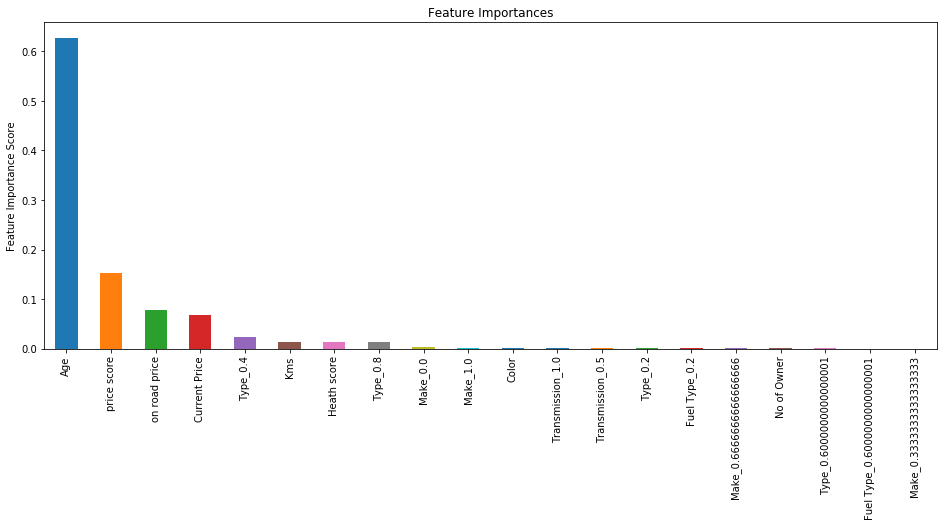

In [75]:
feat_imp = pd.Series(dtree.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp = feat_imp[feat_imp > 0.0]
plt.figure(figsize=(16,6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### RandomForest Regressor

In [353]:
random_forest = RandomForestRegressor(n_estimators=300, criterion='mse', max_depth=5, min_samples_split=2, 
                                      min_samples_leaf=1, min_weight_fraction_leaf=0.01, max_features='sqrt',random_state=51)

In [354]:
random_forest.fit(X_train, y_train)
rforest_train_pred = random_forest.predict(X_train)
print(rmsle(y_train, rforest_train_pred))
print(mean_absolute_error(y_train, rforest_train_pred))
print('R squared: {}'.format(round(random_forest.score(X_train, y_train),4)))

7.7841738949007775
5.995332567195037
R squared: 0.7972


In [355]:
random_forest.fit(X_test, y_test)
rforest_test_pred = random_forest.predict(X_test)
print(rmsle(y_test, rforest_test_pred))
print(mean_absolute_error(y_test, rforest_test_pred))
print('R squared: {}'.format(round(random_forest.score(X_test, y_test),4)))

7.794499999492362
6.031116349224584
R squared: 0.7873


Text(0,0.5,'Feature Importance Score')

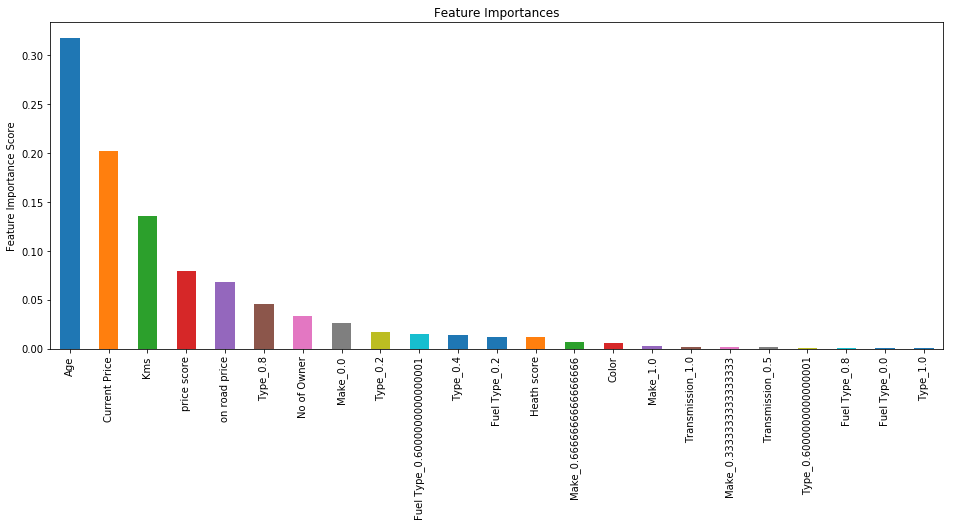

In [356]:
feat_imp = pd.Series(random_forest.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp = feat_imp[feat_imp > 0.0]
plt.figure(figsize=(16,6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### AdaBoost

In [23]:
ada_boost = AdaBoostRegressor(RandomForestRegressor(n_estimators=300, criterion='mse', max_depth=5, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.05, max_features='sqrt',random_state=51),
                              n_estimators=300, loss='linear' , random_state=51, learning_rate= 0.8)

In [24]:
ada_boost.fit(X_train, y_train)
adaboost_train_pred = ada_boost.predict(X_train)
print(rmsle(y_train, adaboost_train_pred))
print(mean_absolute_error(y_train, adaboost_train_pred))
print('R squared: {}'.format(round(ada_boost.score(X_train, y_train),4)))

7.935057070749226
6.212385334200436
R squared: 0.7892


In [25]:
ada_boost.fit(X_test, y_test)
adaboost_test_pred = ada_boost.predict(X_test)
print(rmsle(y_test, adaboost_test_pred))
print(mean_absolute_error(y_test, adaboost_test_pred))
print('R squared: {}'.format(round(ada_boost.score(X_test, y_test),4)))

8.119097004124098
6.396082387890298
R squared: 0.7692


Text(0,0.5,'Feature Importance Score')

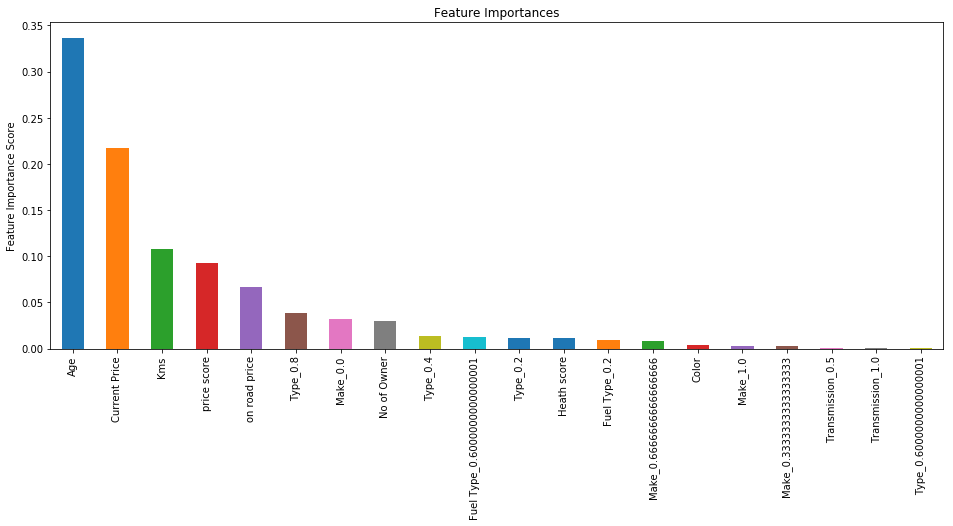

In [452]:
feat_imp = pd.Series(ada_boost.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp = feat_imp[feat_imp > 0.0]
plt.figure(figsize=(16,6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [33]:
print(ada_boost.score(X_train,y_train))
print(ada_boost.score(X_test,y_test))

0.7678912750737253
0.7691804369998598


In [36]:
kf = KFold(n_splits=2,random_state=101,shuffle=True) 

In [37]:
kf.get_n_splits(X_train)

2

In [50]:
for train_index, test_index in kf.split(X_train):
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X_train[train_index], X_test[test_index]
    y_train, y_test = y_train[train_index], y_test[test_index]

TRAIN: [   1    3    8 ... 2696 2698 2699] TEST: [   0    2    4 ... 2692 2695 2697]


KeyError: '[   1    3    8 ... 2696 2698 2699] not in index'

In [49]:
# Perform 6-fold cross validation
scores = cross_val_score(ada_boost, X_train, y_train, cv=6)
print ('Cross-validated scores:', scores)

Cross-validated scores: [0.7955124  0.80213018 0.79357511 0.78553644 0.77544204 0.76100946]


#### Gradient Boosting

In [413]:
GBoost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.25,
                                   max_depth=6, max_features='sqrt',
                                   min_samples_leaf=1, min_samples_split=2, 
                                   loss='huber', random_state =51)

In [414]:
GBoost.fit(X_train, y_train)
GBoost_train_pred = GBoost.predict(X_train)
print(rmsle(y_train, GBoost_train_pred))
print(mean_absolute_error(y_train, GBoost_train_pred))
print('R squared: {}'.format(round(GBoost.score(X_train, y_train),4)))

0.1412363155934272
0.02761545127842129
R squared: 0.9999


In [415]:
GBoost.fit(X_test, y_test)
GBoost_test_pred = GBoost.predict(X_test)
print(rmsle(y_test, GBoost_test_pred))
print(mean_absolute_error(y_test, GBoost_test_pred))
print('R squared: {}'.format(round(GBoost.score(X_test, y_test),4)))

0.04125710445204458
0.006150637374333677
R squared: 1.0


Text(0,0.5,'Feature Importance Score')

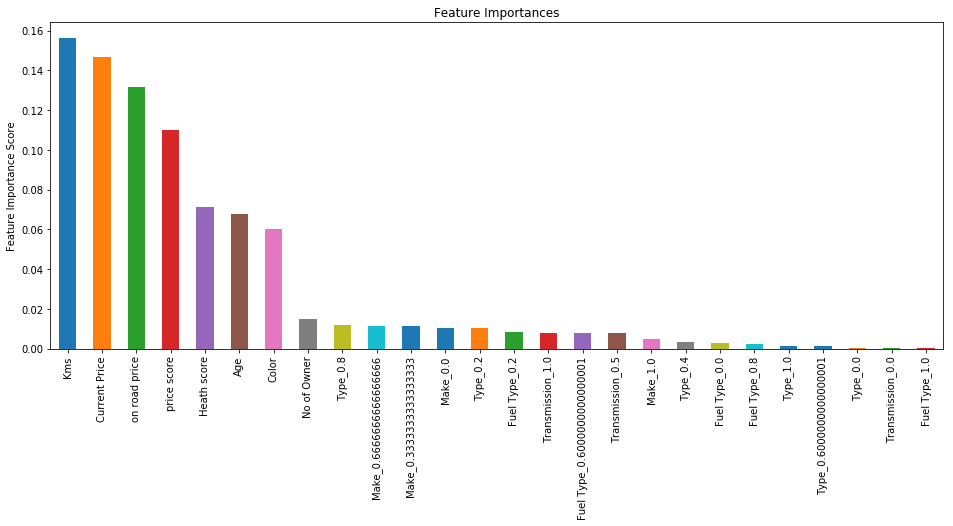

In [416]:
feat_imp = pd.Series(GBoost.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp = feat_imp[feat_imp > 0.0]
plt.figure(figsize=(16,6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### XgBoost

In [109]:
model_xgb = xgb.XGBRegressor(learning_rate=0.01, max_depth=6,n_estimators=1000,random_state =51, nthread = -1)

In [110]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
print(rmsle(y_train, xgb_train_pred))
print(mean_absolute_error(y_train, xgb_train_pred))
print('R squared: {}'.format(round(model_xgb.score(X_train, y_train),4)))

0.9071438250187562
0.698012904001249
R squared: 0.9972


In [111]:
model_xgb.fit(X_test, y_test)
xgb_test_pred = model_xgb.predict(X_test)
print(rmsle(y_test, xgb_test_pred))
print(mean_absolute_error(y_test, xgb_test_pred))
print('R squared: {}'.format(round(model_xgb.score(X_test, y_test),4)))

0.7235539304266011
0.550928693559171
R squared: 0.9982


Text(0,0.5,'Feature Importance Score')

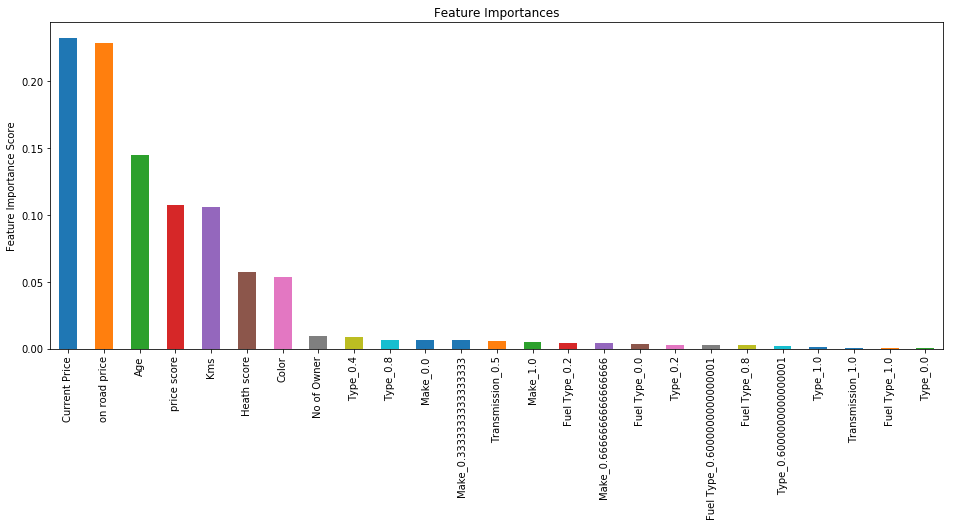

In [127]:
feat_imp = pd.Series(model_xgb.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp = feat_imp[feat_imp > 0.0]
plt.figure(figsize=(16,6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### LightGBM

In [112]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.1, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [113]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
print(rmsle(y_train, lgb_train_pred))
print(mean_absolute_error(y_train, lgb_train_pred))
print('R squared: {}'.format(round(model_lgb.score(X_train, y_train),4)))

2.47954891393149
1.8599390967305425
R squared: 0.9794


In [114]:
model_lgb.fit(X_test, y_test)
lgb_test_pred = model_lgb.predict(X_test)
print(rmsle(y_test, lgb_test_pred))
print(mean_absolute_error(y_test, lgb_test_pred))
print('R squared: {}'.format(round(model_lgb.score(X_test, y_test),4)))

1.9411621727088384
1.4823170952975455
R squared: 0.9868


Text(0,0.5,'Feature Importance Score')

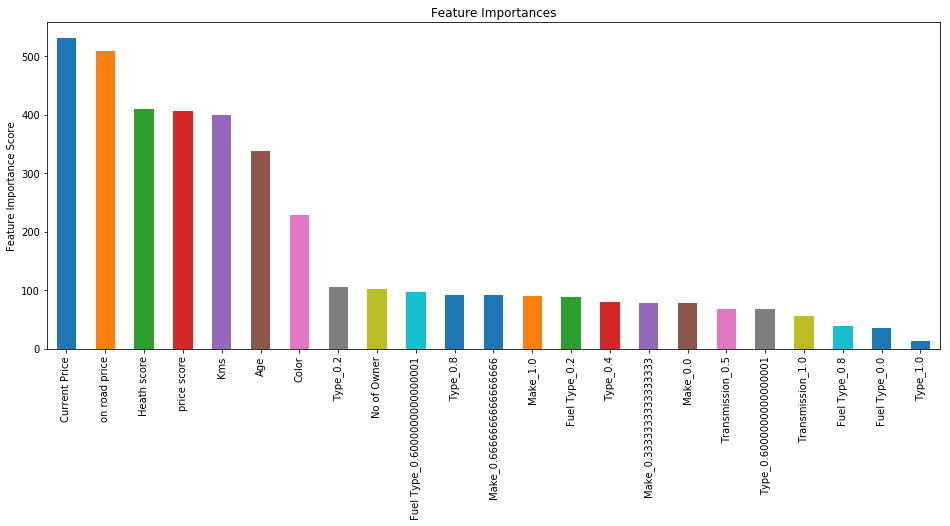

In [128]:
feat_imp = pd.Series(model_lgb.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp = feat_imp[feat_imp > 0.0]
plt.figure(figsize=(16,6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Stacked Regressor

In [115]:
st_regr = StackingRegressor(regressors=[model_lgb, GBoost, ada_boost], meta_regressor=model_xgb)

In [116]:
st_regr.fit(X_train, y_train)
st_regr_train_pred = st_regr.predict(X_train)
print(rmsle(y_train, st_regr_train_pred))
print(mean_absolute_error(y_train, st_regr_train_pred))
print('R squared: {}'.format(round(st_regr.score(X_train, y_train),4)))

0.36862693919489714
0.23895412061435106
R squared: 0.9995


In [117]:
st_regr.fit(X_test, y_test)
st_regr_test_pred = st_regr.predict(X_test)
print(rmsle(y_test, st_regr_test_pred))
print(mean_absolute_error(y_test, st_regr_test_pred))
print('R squared: {}'.format(round(st_regr.score(X_test, y_test),4)))

0.2545779644877649
0.14495886342309397
R squared: 0.9998


### As we see above, the best model with least errors is the stacked regressor model. But that can be overfitting also.

### Feature Importance

#### Checking for Adaboost

Text(0,0.5,'Feature Importance Score')

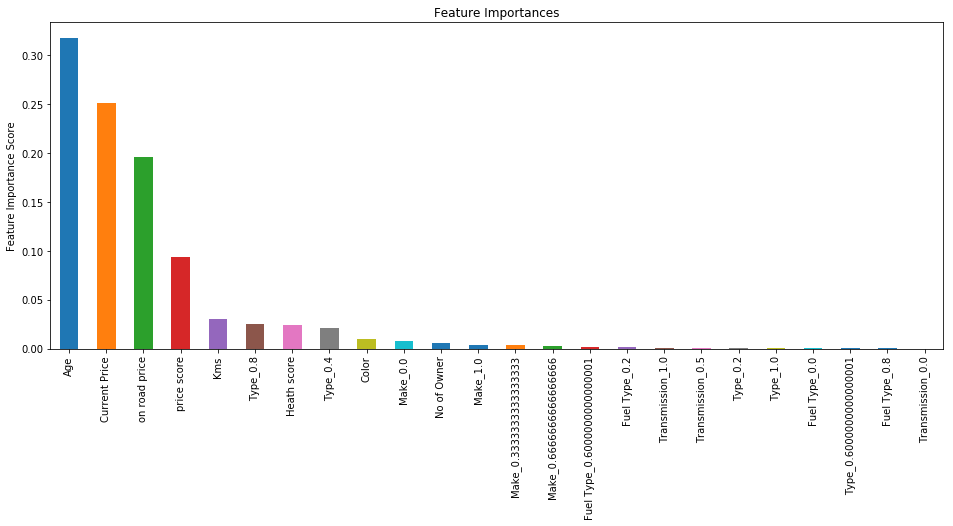

In [253]:
feat_imp = pd.Series(ada_boost.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp = feat_imp[feat_imp > 0.0]
plt.figure(figsize=(16,6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [259]:
imp_features = feat_imp.nlargest(8)
imp_features

Age              0.317612
Current Price    0.250769
on road price    0.195997
price score      0.094096
Kms              0.030722
Type_0.8         0.024796
Heath score      0.024517
Type_0.4         0.020983
dtype: float64

In [260]:
X_train_feat = X_train[['Age','Current Price','on road price','Kms','Type_0.8','Heath score','Type_0.4']]

In [261]:
ada_boost.fit(X_train_feat, y_train)
adaboost_train_pred = ada_boost.predict(X_train_feat)
print(rmsle(y_train, adaboost_train_pred))
print(mean_absolute_error(y_train, adaboost_train_pred))
print('R squared: {}'.format(round(ada_boost.score(X_train_feat, y_train),4)))

2.8541852830429795
2.423325065687854
R squared: 0.9727


In [262]:
X_test_feat = X_test[['Age','Current Price','on road price','Kms','Type_0.8','Heath score','Type_0.4']]

In [264]:
ada_boost.fit(X_test_feat, y_test)
adaboost_test_pred = ada_boost.predict(X_test_feat)
print(rmsle(y_test, adaboost_test_pred))
print(mean_absolute_error(y_test, adaboost_test_pred))
print('R squared: {}'.format(round(ada_boost.score(X_test_feat, y_test),4)))

3.067908940736822
2.617121354189796
R squared: 0.967


### Plotting actual v/s predictions

Text(0,0.5,'Predictions')

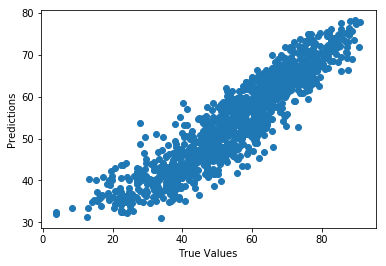

In [29]:
plt.scatter(y_test, adaboost_test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

### Saving the model

In [130]:
# Save the trained model to a file so we can use it in other programs
joblib.dump(st_regr, '../Datasets/trained_car_regreesor_model.pkl')

['../Datasets/trained_car_regreesor_model.pkl']

#### Combining the final results

In [453]:
x = pd.DataFrame(data=adaboost_train_pred,index=y_train.index)
y = pd.DataFrame(data=adaboost_test_pred,index=y_test.index)
z = pd.concat([x,y])

In [439]:
z.sort_index(ascending=True).head()

,0
0,37.103385
1,64.108963
2,48.289456
3,34.944346
4,69.037202


In [350]:
df_sub.head()

,Make,Model,Age,Variant,Transmission,Color,No of Owner,Kms,Type,Fuel Type,on road price,Dep,Predicted_dep
0,Hyundai,I10,3,Sportz 1.2,Manual,White,1,12000,Hatchback,PETROL,5.378497e+05,37.091715,37.672435
1,Hyundai,I20,9,Magna (O) 1.2,Manual,Beige,1,68000,Hatchback,PETROL,6.138627e+05,69.178775,62.419439
2,Hyundai,I20,8,Sportz 1.2,Manual,White,1,31143,Hatchback,PETROL,6.783586e+05,48.763381,48.860337
3,Hyundai,Neo Fluidic Elantra,2,1.6SxAtCrdi,Automatic,Silver,1,6000,Sedan,DIESEL,2.228480e+06,26.889645,37.239544
4,Hyundai,Santro Xing,11,Xo,Manual,Golden,2,100000,Hatchback,PETROL,4.537194e+05,80.992656,69.071230


In [454]:
df_sub['Predicted_dep'] = pd.DataFrame(z)

In [169]:
df_sub.head(10).round(3)

,Make,Model,Age,Variant,Transmission,Color,No of Owner,Kms,Type,Fuel Type,on road price,Dep,Predicted_dep
0,Hyundai,I10,3,Sportz 1.2,Manual,White,1,12000,Hatchback,PETROL,537849.665,37.092,32.444
1,Hyundai,I20,9,Magna (O) 1.2,Manual,Beige,1,68000,Hatchback,PETROL,613862.680,69.179,69.053
2,Hyundai,I20,8,Sportz 1.2,Manual,White,1,31143,Hatchback,PETROL,678358.572,48.763,49.204
3,Hyundai,Neo Fluidic Elantra,2,1.6SxAtCrdi,Automatic,Silver,1,6000,Sedan,DIESEL,2228480.499,26.890,26.179
4,Hyundai,Santro Xing,11,Xo,Manual,Golden,2,100000,Hatchback,PETROL,453719.368,80.993,74.071
5,Hyundai,Grand I10,3,Asta 1.2 Kappa VTVT,Manual,Red,1,45000,Hatchback,PETROL,752105.000,51.638,45.040
6,Hyundai,Accent,11,GLS,Manual,Silver,1,78484,Sedan,PETROL,691110.636,85.357,80.473
7,Hyundai,I10,10,Magna,Manual,Red,2,55000,Hatchback,PETROL + CNG,462988.363,64.837,66.719
8,Hyundai,I10,11,Era,Manual,Grey,2,68000,Hatchback,PETROL,446864.390,69.476,71.617
9,Hyundai,Creta,3,1.6Sx+AtDiesel,Automatic,White,1,4500,SUV,DIESEL,1741999.316,29.104,31.231


In [455]:
df_sub.loc[(df_sub['Model'] == 'I10') & (df_sub['Variant'] == 'Magna 1.1 iRDE2') & (df_sub['Age'] == 4)]

,Make,Model,Age,Variant,Transmission,Color,No of Owner,Kms,Type,Fuel Type,on road price,Dep,Predicted_dep
440,Hyundai,I10,4,Magna 1.1 iRDE2,Manual,White,1,13000,Hatchback,PETROL,541569.725852,30.528007,37.261990
497,Hyundai,I10,4,Magna 1.1 iRDE2,Manual,Maroon,1,6300,Hatchback,PETROL,541569.725852,40.409978,36.430996
1099,Hyundai,I10,4,Magna 1.1 iRDE2,Manual,Silver,1,26000,Hatchback,PETROL,541569.725852,36.673343,37.194064
3838,Hyundai,I10,4,Magna 1.1 iRDE2,Manual,White,1,29000,Hatchback,PETROL,541569.725852,42.780391,42.258896


In [123]:
df_sub.describe()

,No of Owner,Kms,on road price,Dep,Predicted_dep
count,3858.000000,3858.000000,3.858000e+03,3858.000000,3858.000000
mean,1.225505,56014.082167,9.355707e+05,54.393758,54.390957
std,0.547417,38682.482324,5.591599e+05,17.174109,17.161194
min,1.000000,863.000000,2.372747e+05,2.071667,2.271385
25%,1.000000,38000.000000,5.415697e+05,42.224652,42.382694
50%,1.000000,53000.000000,7.819281e+05,55.274488,55.280361
75%,1.000000,68414.500000,1.120298e+06,67.264135,67.260857
max,6.000000,750000.000000,3.908606e+06,92.453905,92.073151


In [132]:
df_sub.to_excel('../Datasets/Final_submission.xlsx',index=False)